# Plotting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex
import gizmo_analysis as ga
import sys
sys.path.append('../mock')
import allvariables

## Access Mock Parameters

Here we are declaring all the `config.yaml` file parameters as local parameters.

In [2]:
# Get the parameters from the config file
params = allvariables.getparamsnotebook()

# Define parameter names
param_names = [
        "snap", "sim", "sim_dir", "sat_id_dir", "rmin", "rmax", "sat_mask", "ananke_name", 
        "photo_sys", "cmd_magnames", "app_mag_lim_lo", "app_mag_lim_hi", 
        "abs_mag_lim_lo", "abs_mag_lim_hi", "ananke_r_max", "fsample"
]

# Initialize parameter dictionary
params_dict = {}

# Assign values to parameters and declare them locally
for param_name, param_value in zip(param_names, params):
    params_dict[param_name] = param_value
    locals()[param_name] = param_value

## Access Ananke Data

Here we are accessing the data with and without the satellite included. Thus, we are working with two different surveys. 

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b.h5")
ananke_sat_file_path = os.path.join(current_dir, "..", "mock", "survey.anankethon_LSST_outer_m12b_sat.h5")
print(f"\nOpening data from: \n{ananke_file_path} \n{ananke_sat_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print(f"{ananke_file_path} file does not exist.")
    
# Check if the file exists
if os.path.exists(ananke_sat_file_path):
    # Proceed with opening the file
    survey_sat = vaex.open(ananke_sat_file_path)
else:
    print(f"{ananke_sat_file_path} file does not exist.")


Opening data from: 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b.h5 
/home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.anankethon_LSST_outer_m12b_sat.h5


In [4]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'calcium', 'carbon', 'dec', 'dform', 'dmod', 'feh', 'glat', 'glon', 'grav', 'helium', 'lsst_gmag', 'lsst_gmag_Err', 'lsst_gmag_Intrinsic', 'lsst_gmag_Sig', 'lsst_imag', 'lsst_imag_Err', 'lsst_imag_Intrinsic', 'lsst_imag_Sig', 'lsst_rmag', 'lsst_rmag_Err', 'lsst_rmag_Intrinsic', 'lsst_rmag_Sig', 'lsst_umag', 'lsst_umag_Err', 'lsst_umag_Intrinsic', 'lsst_umag_Sig', 'lsst_ymag', 'lsst_ymag_Err', 'lsst_ymag_Intrinsic', 'lsst_ymag_Sig', 'lsst_zmag', 'lsst_zmag_Err', 'lsst_zmag_Intrinsic', 'lsst_zmag_Sig', 'lum', 'mact', 'magnesium', 'mtip', 'mub', 'mudec', 'mul', 'mura', 'neon', 'nitrogen', 'oxygen', 'parentid', 'partid', 'pi', 'px', 'py', 'pz', 'ra', 'rad', 'silicon', 'smass', 'sulphur', 'teff', 'vr', 'vx', 'vy', 'vz']


## Access FIRE Data

In [5]:
redshift = 0.
    
part = ga.io.Read.read_snapshots(species='star',
                                 snapshot_value_kind='redshift',
                                 snapshot_values=redshift,
                                 simulation_directory=sim_dir,
                                 elements='all',
                                 assign_hosts=True,
                                 assign_hosts_rotation=True,
                                 assign_orbits=True)


# in utilities.simulation.Snapshot():
* reading:  home/jovyan/data/fire2/m12b_res7100/snapshot_times.txt

* input redshift = 0.0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/jovyan/data/fire2/m12b_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 74537000 particles
    dark2     (id = 2): 6750970 particles
    gas       (id = 0): 58588459 particles
    star      (id = 4): 16869462 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5
    snapshot_600.4.hdf5
    snapshot_600.5.hdf5
    snapshot_600.6.hdf5
    snapshot_600.7.hdf5

* reading cosmological parameters from:  home/jovyan/data/fire2/m12b_res7100/initial_condition/ic_agora_m12b.conf

* checking sanity of particle properties
! 

## Extract Parameters

In [6]:
# Define the bin edges
bins = 200  

### 1. Data before ananke (FIRE)

In [21]:
firePos = part['star'].prop('host.distance') # star position in kpc
fireMass = part['star']['mass']              # star mass in Msun
fireVel = part['star'].prop('host.velocity') # star velocity in km/s

In [22]:
# Compute radial distance
fireRadial = np.sqrt((firePos[:,0])**2 + (firePos[:,1])**2 + (firePos[:,2])**2)

# Compute the FIRE density profile
fireCounts, fireEdges = np.histogram(fireRadial, bins=bins, range=(rmin, rmax))
fireVolume = 4.0/3.0 * np.pi * (np.power(fireEdges[1:], 3) - np.power(fireEdges[:-1], 3))
fireDensity = fireCounts / fireVolume

### 2. Data after ananke

In [7]:
# Extract parameters
anankeRadial = survey.rad.to_numpy()
anankeMass = survey.smass.to_numpy()            
anankeVel = survey.vr.to_numpy()

In [8]:
# Compute the ananke density profile
anankeCounts, anankeEdges = np.histogram(anankeRadial, bins=bins, range=(rmin, rmax))
anankeVolume = 4.0/3.0 * np.pi * (np.power(anankeEdges[1:], 3) - np.power(anankeEdges[:-1], 3))
anankeDensity = anankeCounts / anankeVolume

### 3. BHB

To select BHB stars  we use $ 0.98 < u − g < 1.28$, $−0.27 < g − r < −0.06$ and excluding the region $([u−g −0.98]/0.215)2 + ([g −r+ 0.06]/0.17)2 < 1$.

In [9]:
# Extract apparent magnitudes
app_g_mag = survey.lsst_gmag.to_numpy()
app_r_mag = survey.lsst_rmag.to_numpy()
app_i_mag = survey.lsst_imag.to_numpy()
app_u_mag = survey.lsst_umag.to_numpy()
app_y_mag = survey.lsst_ymag.to_numpy()
app_z_mag = survey.lsst_zmag.to_numpy()

In [10]:
# Calculate u - g
u_minus_g = app_u_mag - app_g_mag

In [11]:
# Calculate g - r
g_minus_r = app_g_mag - app_r_mag

In [12]:
# Create BHB mask
bhb_mask = ((u_minus_g > 0.98) & (u_minus_g < 1.28) &
            (g_minus_r > -0.27) & (g_minus_r < -0.06) &
            ((((u_minus_g - 0.215) / 0.215) * 2 + ((g_minus_r + 0.06) / 0.17) * 2) >= 1))

In [13]:
# Compute the BHB density profile
bhbCounts, bhbEdges = np.histogram(anankeRadial[bhb_mask], bins=bins, range=(rmin, rmax))
bhbVolume = 4.0/3.0 * np.pi * (np.power(bhbEdges[1:], 3) - np.power(bhbEdges[:-1], 3))
bhbDensity = bhbCounts / bhbVolume

### 4. K Giant

In order to isolate K giants in our stellar halo models we have used the colour cuts $0.5 < g − r < 1.3$ and $0.5 <
u−g < 3.5$ from Xue et al. (2014), along with their proposed empirical polynomial relation between (g −r) and [Fe/H] to remove red horizontal branch and red-clump (RC) giants. All stars with $(g − r) > 0.087 [Fe/H]2 + 0.39 [Fe/H] + 0.96$ is excluded from the selection. An additional cut of $M_g < 4$ removes faint dwarf stars of the same colours

In [14]:
# Extract absolute magnitudes
# NOTE: THIS VALUE IS NOT ACTUALLY ABS MAGNITUDE
g_mag = survey.lsst_gmag_Intrinsic.to_numpy()
r_mag = survey.lsst_rmag_Intrinsic.to_numpy()
i_mag = survey.lsst_imag_Intrinsic.to_numpy()
u_mag = survey.lsst_umag_Intrinsic.to_numpy()
y_mag = survey.lsst_ymag_Intrinsic.to_numpy()
z_mag = survey.lsst_zmag_Intrinsic.to_numpy()

In [15]:
# Extract metalicity
feh = survey.feh.to_numpy()

In [16]:
# Create K Giant mask
kgiant_mask = ((g_minus_r > 0.5) & (g_minus_r < 1.3) &
               (u_minus_g > 0.5) & (u_minus_g < 3.5) &
               (g_minus_r <= ((0.087 * feh * 2) + (0.39 * feh) + 0.96)) & 
               (g_mag < 4))

In [17]:
# Compute the K Giant density profile
kgiantCounts, kgiantEdges = np.histogram(anankeRadial[kgiant_mask], bins=bins, range=(rmin, rmax))
kgiantVolume = 4.0/3.0 * np.pi * (np.power(kgiantEdges[1:], 3) - np.power(kgiantEdges[:-1], 3))
kgiantDensity = kgiantCounts / kgiantVolume

### 5. MSTO

To select main sequence turn off stars we use $ 0.2 < g−r < 0.4$ and $M_g > 4$.

In [18]:
# Create MSTO mask
msto_mask = (g_minus_r > 0.2) & (g_minus_r < 0.4) & (g_mag > 4)

In [19]:
# Compute the MSTO density profile
mstoCounts, mstoEdges = np.histogram(anankeRadial[msto_mask], bins=bins, range=(rmin, rmax))
mstoVolume = 4.0/3.0 * np.pi * (np.power(mstoEdges[1:], 3) - np.power(mstoEdges[:-1], 3))
mstoDensity = mstoCounts / mstoVolume

## Plotting

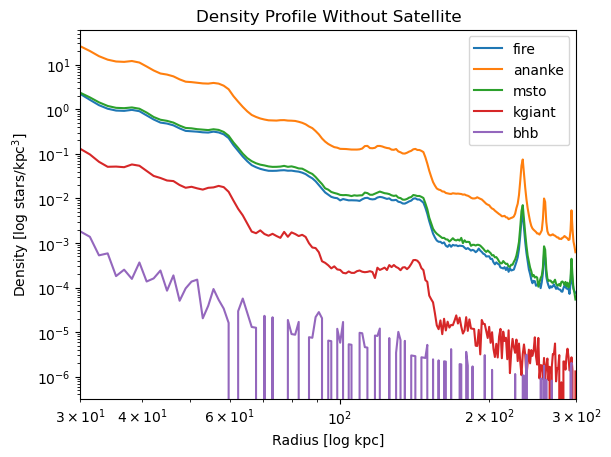

In [23]:
# Plot the density profile
fig, ax = plt.subplots()
ax.loglog(fireEdges[:-1], fireDensity, label='fire')
ax.loglog(anankeEdges[:-1], anankeDensity, label='ananke')
ax.loglog(mstoEdges[:-1], mstoDensity, label='msto')
ax.loglog(kgiantEdges[:-1], kgiantDensity, label='kgiant')
ax.loglog(bhbEdges[:-1], bhbDensity, label='bhb')
ax.set_xlabel('Radius [log kpc]')
ax.set_ylabel('Density [log stars/kpc$^3$]')
ax.set_xlim(rmin, rmax)
ax.set_ylim()
ax.legend()
plt.title('Density Profile Without Satellite')
plt.show()